## Implementing the Quantitative Natural Language Inference (QNLI) task by finetuning EQUATE on RoBERT , based on different number representations. Here , we try to replicate the experiments of last year paper and Have ourselves the code ready for our own new and upcoming ones <3



( with this code when my pretrained from scratch QuantitativeBERT or QuantitativeRoberta model itself is ready , We can simply replace ours instead of original BERT or Roberta Models . since my teammates have seeemingly done the last two tasks , I am doing this one.But, I took my time explaning the code and the task in detail so that it can be used for future tasks as well. My teammates can use this code for their tasks as well and learn from it. )

Here are the key steps conceptually:

1. **Data Preparation**
   - We have the QNLI-Stress test dataset with train/dev/test splits 
   - It contains premise-hypothesis statement pairs labeled 'answers' as entailment/neutral/contradiction
   - We use this labeled data to teach our model for inference

2. **Model**
   - Load a pretrained RoBERT model 
   - Add a Classification Head (Linear layer) on top for 2-class prediction
   - This head will predict entailment vs neutral vs contradiction given three different vector representations of the premise-hypothesis pair 
   ( original vs scientific notaion vs digitized )

3. **Finetune BERT + Classifier Model** 
   - Jointly finetune the RoBerta layers AND the classification head 
   - We pass the concatenated premise-hypothesis strings through Roberta to get vector representations
   - Feed the vectors to classifier head to predict entailment or Neutral or contradiction probability 
   - Update the whole model end-to-end by comparing predictions with true labels

4. **Inference**
   - For a new premise-hypothesis pair
   - Get vector outputs from finetuned RoBERT model
   - Pass vectors to the tuned classifier head 
   - It will predict if hypothesis is entailed or neutral or contradiction w.r.t premise quantities

In summary, you finetune RoBERT in conjunction with an added classifier layer in an end-to-end fashion. This tuning teaches the linguistic inference logic. The finetuned model can then be used for inference on new examples.


In [81]:
#import some necessary librairies
import torch
import pandas as pd
import numpy as np

import seaborn as sns
import transformers
from transformers import TrainingArguments, Trainer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AdamW
import json
from torch.utils.data import Dataset, DataLoader
# import logist


In [82]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05

In [83]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

device

'cpu'

## QNLI - Quantitative Natural Language Inference



1. **Data Preparation**
   - We have the QNLI-Stress test dataset with train/dev/test splits 
   - It contains premise-hypothesis statement pairs labeled as entailment/neutral
   - We use this labeled data to teach our model for inference

In [84]:
with open('QNLI_QNLI-Stress Test_QNLI-Stress Test_train.json', 'r') as file:
    training_data = json.load(file)
    training_df = pd.DataFrame(training_data)


In [85]:
#see the data
print(training_df.head())

                                          statement1  \
0  '' Someone just came in and shot my daughter a...   
1                      A $ 5,000 reward is offered .   
2   At Veridux Corporation , there are 250 employees   
3  The ratio between the number of sheep and the ...   
4  More than 1.2 million people have since viewed...   

                                          statement2  \
0  Raul Flores , daughter , 9 , shot dead ; wire ...   
1  Know something ? Call 641-228-182 . A reward i...   
2  At Veridux Corporation , there are less than 6...   
3  The ratio between the number of sheep and the ...   
4  Over 1.2 million people have viewed it on YouTube   

                                    options         answer    type  \
0                    Entailment or neutral?        neutral  Type_7   
1                    Entailment or neutral?        neutral  Type_7   
2   Entailment or contradiction or neutral?     Entailment  Type_7   
3   Entailment or contradiction or neutral?  c

In [86]:
# Load and preprocess validation dataset from another JSON file
with open('QNLI_QNLI-Stress Test_QNLI-Stress Test_dev.json', 'r') as file:
    validation_data = json.load(file)
    validation_df = pd.DataFrame(validation_data)

In [87]:
#see the data
print(validation_df.head())



                                          statement1  \
0  Patrick has a locker with a less than 8 number...   
1  Jessica can text more than 35 words per minute...   
2  Shaquan has more than 3 playing cards , each o...   
3  In a friendship gang Andrew has 8 gang , in ho...   
4  Since you ' re nice , you give John 2 baseball...   

                                          statement2  \
0   Patrick has a locker with a 3 number combination   
1  Jessica can text 75 words per minute , while M...   
2  Shaquan has 5 playing cards , each one is orde...   
3  In a friendship gang Andrew has more than 5 ga...   
4  Since you ' re nice , you give John more than ...   

                                    options         answer    type  \
0   Entailment or contradiction or neutral?        neutral  Type_7   
1   Entailment or contradiction or neutral?        neutral  Type_7   
2   Entailment or contradiction or neutral?        neutral  Type_7   
3   Entailment or contradiction or neutral?   

In [88]:
# load test dataset
with open('QNLI_QNLI-Stress Test_QNLI-Stress Test_test.json', 'r') as file:
    test_data = json.load(file)
    test_df = pd.DataFrame(test_data)

#see the data
print(test_df.head())

                                          statement1  \
0  Roshan is 5 years younger than Raj and they ha...   
1  In a friendship gang Andrew has 8 gang , in ho...   
2  There are 4 chess amateurs playing in Villa ' ...   
3  Each of three charities in Novel Grove Estates...   
4  NHAI employs less than 600 men to build a high...   

                                          statement2  \
0  Roshan is 2 years younger than Raj and they ha...   
1  In a friendship gang Andrew has more than 3 ga...   
2  There are more than 4 chess amateurs playing i...   
3  Each of three charities in Novel Grove Estates...   
4  NHAI employs 100 men to build a highway of 2 k...   

                                    options         answer    type  \
0   Entailment or contradiction or neutral?  contradiction  Type_7   
1   Entailment or contradiction or neutral?     Entailment  Type_7   
2   Entailment or contradiction or neutral?  contradiction  Type_7   
3   Entailment or contradiction or neutral?  c

In [89]:
#let's check the shape of the data
print(training_df.shape)


(6475, 14)


In [90]:
# let's check unique labels
training_df['answer'].unique()

array(['neutral', 'Entailment', 'contradiction'], dtype=object)

In [91]:
# okay there are 3 unique labels, let's encode them
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
training_df['label'] = label_encoder.fit_transform(training_df['answer'])
validation_df['label'] = label_encoder.transform(validation_df['answer'])
test_df['label'] = label_encoder.transform(test_df['answer'])

# let's check the unique labels again
training_df['label'].unique()


array([2, 0, 1])

C:\Users\pyaes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

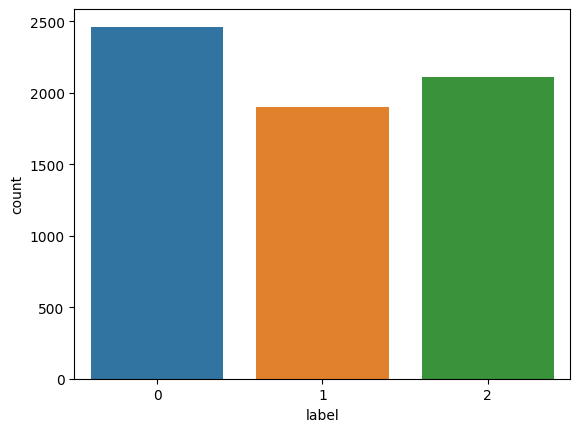

In [92]:
# let's check the distribution of the labels
sns.countplot(training_df['label'])

['Entailment' 'contradiction' 'neutral']

there is a little bit of class imbalance in the dataset , but it is not too much to worry about.

In [93]:
# see the classes
print(label_encoder.classes_)

['Entailment' 'contradiction' 'neutral']


<u>**Dataset split**</u> 
since we will train on cpu , we will use only 1000 samples for training and 100 samples for validation


In [94]:
# since we will train on cpu , we will use only 1000 samples for training and 100 samples for validation 
# let's shuffle the data
training_df = training_df.sample(frac=1).reset_index(drop=True)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# let's take only 1000 samples for training and 100 samples for validation
training_df = training_df[:1000]
validation_df = validation_df[:100]
test_df = test_df[:100]

In [95]:
# let's check the shape of the data
print(training_df.shape)

(1000, 15)


In [96]:
# let's see how the data looks now
print(training_df.head())

                                          statement1  \
0  Salley ' s internet provider offers unlimited ...   
1  Arun purchased less than 50 kg of wheat at the...   
2  If twice the age of Sunil is more than Syam ' ...   
3  If Snyder has less than 7 more men and 6 more ...   
4  Calculate the average mark scored by Nancy if ...   

                                          statement2  \
0  Salley ' s internet provider offers unlimited ...   
1    Arun purchased 30 kg of wheat at the rate of Rs   
2  If twice the age of Sunil is more than Syam ' ...   
3  If Snyder has 4 more men and 6 more women than...   
4  Calculate the average mark scored by Nancy if ...   

                                    options         answer    type  \
0   Entailment or contradiction or neutral?  contradiction  Type_7   
1   Entailment or contradiction or neutral?        neutral  Type_7   
2   Entailment or contradiction or neutral?     Entailment  Type_7   
3   Entailment or contradiction or neutral?   

In [97]:
# let's see the unique labels
training_df['label'].unique()

array([1, 2, 0])

In [98]:
# let's check the columns 
training_df.columns

Index(['statement1', 'statement2', 'options', 'answer', 'type',
       'statement1_sci_10E', 'statement1_char', 'statement1_sci_10E_char',
       'statement2_sci_10E', 'statement2_char', 'statement2_sci_10E_char',
       'statement1_mask', 'statement2_mask', 'EQUATE', 'label'],
      dtype='object')

In [99]:
# check the type of the columns
training_df.dtypes

statement1                 object
statement2                 object
options                    object
answer                     object
type                       object
statement1_sci_10E         object
statement1_char            object
statement1_sci_10E_char    object
statement2_sci_10E         object
statement2_char            object
statement2_sci_10E_char    object
statement1_mask            object
statement2_mask            object
EQUATE                     object
label                       int32
dtype: object

In [100]:
#  statement 1 mask  unique values
training_df['statement1_mask'].unique()

array(["Salley ' s internet provider offers unlimited traffic which costs $ [Num] per day charged off at [Num] a",
       'Arun purchased less than [Num] kg of wheat at the rate of Rs',
       "If twice the age of Sunil is more than Syam ' s age by [Num] years , what is Sunil ' s age ?",
       'If Snyder has less than [Num] more men and [Num] more women than Leigh , how many men are in the Snyder choir ?',
       'Calculate the average mark scored by Nancy if she obtained the following scores in an examination : less than [Num] , [Num] , [Num] , [Num] and [Num] marks ( out of [Num] ) in English Language , Physics , Mathematics , Chemistry and Biology ?',
       'Ratio between Rahul and Deepak is [Num] : [Num] , After [Num] Years Rahul age will be [Num]6 years',
       'Mary can divide his herd into [Num] equal parts and also to [Num] equal parts , but not to [Num] equal parts',
       'The herd broke through three strands of high tensile barbed wire to escape the farm , and later swam

2. **Model**
   - Load a pretrained BERT model 
   - Add a Classification Head (Linear layer) on top for 2-class prediction
   - This head will predict entailment vs neutral given vector representations 

In [101]:
#define auto tokenizer import
import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch


# define the model name
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

why Roberta? The process of fine-tuning a pre-trained language model for a specific task is generally the same, regardless of whether we are using BERT or RoBERTa. The main difference lies in the architecture of the pre-trained model itself.

BERT (Bidirectional Encoder Representations from Transformers) was one of the earliest and most successful pre-trained language models. It achieved state-of-the-art performance on a variety of natural language processing tasks. However, BERT has some limitations, such as its tendency to memorize text rather than truly understanding its meaning.

RoBERTa (Robustly Optimized BERT Pretraining Approach) is a modified version of BERT that addresses some of these limitations. It uses a larger training corpus, removes the next sentence prediction objective, and applies dynamic masking during training. These changes have led to improved performance on a variety of tasks, including QNLI.

Therefore, if you have access to RoBERTa, it is generally recommended to use it instead of BERT. It is a more powerful and versatile model that is better suited for fine-tuning on a variety of tasks.

Here's a summary of the differences between BERT and RoBERTa:

| Feature | BERT | RoBERTa |
|---|---|---|
| Architecture | Bidirectional transformer encoder | Bidirectional transformer encoder with additional improvements |
| Training corpus | Smaller | Larger |
| Next sentence prediction objective | Yes | No |
| Dynamic masking during training | No | Yes |
| Performance on QNLI | Good | Better |

Overall, RoBERTa is a more advanced and effective language model than BERT. 

so yes If we have the option to use RoBERTa, it is the preferred choice for fine-tuning on a variety of NLP tasks.

In [102]:
# now our **Model** configuration
#Load a pretrained RoBERT model 
#Add a Classification Head (Linear layer) on top for 3-class label prediction
#This head will predict from three options : Entailment or contradiction or neutral? given vector representations  

# Load the RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')


# Load the RoBERTa model
model = AutoModelForMaskedLM.from_pretrained('roberta-base')

# Freeze the RoBERTa model weights ? why because ...
for param in model.parameters():
    param.requires_grad = False

# Add a Classification Head (Linear layer) on top of RoBERTa
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 3)
)

# Tell pytorch to run this model on the GPU.
model = model.to(device)

Freeze the RoBERTa model weights ? why because ...

The reason for this is that the pre-trained RoBERTa model has already learned powerful language representations. These representations are likely to be useful for our task, so we want to keep them intact. By freezing the pre-trained weights, we prevent them from being modified during training. This allows us to fine-tune the model without forgetting what it has already learned.

you want more?

When you freeze the weights of the pre-trained RoBERTa model, you're essentially preventing the model from learning anything new. The pre-trained weights represent the knowledge that the model has acquired from its extensive training on a massive dataset of text and code. Freezing these weights ensures that this valuable knowledge remains intact and is not overwritten during the fine-tuning process.

With the pre-trained weights frozen, the only part of the model that is updated is the newly added classification head. This head is responsible for taking the output of the RoBERTa model and transforming it into the desired predictions for the specific task at hand. By fine-tuning the classification head, you're essentially teaching the model how to interpret the pre-trained language representations and make specific decisions for the QNLI task.

This approach of fine-tuning pre-trained models is becoming increasingly popular in NLP because it allows you to leverage the vast knowledge of these models while still tailoring them to your specific task. By freezing the majority of the pre-trained model, you're ensuring that you're not disrupting the model's ability to understand and represent language, while simultaneously allowing you to adapt it to the nuances of your task.

In essence, fine-tuning is about extending the capabilities of a pre-trained model rather than completely retraining it from scratch. You retain the benefits of the pre-trained model's knowledge while adding the ability to perform specific tasks. This approach has led to significant advances in NLP and is widely used for tasks like natural language understanding, machine translation, and text generation.

In [103]:
# let's see the model architecture
model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

The numbers 50265 and 768 in the model architecture represent the sizes of the word embedding matrix and the hidden state size, respectively. The word embedding matrix is a lookup table that maps words to their corresponding word embeddings. The hidden state size is the size of the vectors that the model uses to represent the meaning of words in a sentence.

The size of the word embedding matrix is 50265 because the RoBERTa model was trained on a vocabulary of 50265 words. The size of the hidden state size is 768 because the model uses 768-dimensional vectors to represent the meaning of words in a sentence.

The fact that our training set is a size of (1000,15) does not affect the size of the word embedding matrix or the hidden state size. These sizes are determined by the architecture of the RoBERTa model and are not affected by the size of the training data.


# Prepare our data for finetuning for QNLI task '

NOTE: if you run this code !  

for idx, row in training_df.iterrows():
    premise = row['statement1','statement1_sci_10E', 'statement1_char','statement1_sci_10E_char','statement1_mask']
    hypothesis = row['statement2','statement2_sci_10E', 'statement2_char','statement2_sci_10E_char','statement2_mask']
    label = row['label']
    print(premise, hypothesis, label)

will show this error : 

KeyError : ---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
----> 3     premise = row['statement1','statement1_sci_10E', 'statement1_char','statement1_sci_10E_char','statement1_mask']


Do you know why the above code doesn't work? because i am trying to push everything into premise and hypothesis which is wrong ! Our columns of the datasets are not meant to be used that way. let me explain !

Based on my understanding of the paper, here is how they handled the QNLI task:

1. Data Preparation:
- They used the EQUATE dataset which contains QNLI examples from different sources. 
- For each QNLI example, they experimented with different representations of the numbers:
    - Original: No modification
    - Digit-based: Separate digits with spaces (e.g. 147 -> 1 4 7)
    - Scientific Notation: Convert to scientific notation 
- So for each example, they would have the original premise/hypothesis strings as well as transformed versions.

2. Finetuning: 
- They finetuned BERT and RoBERTa models on the QNLI data. 
- During finetuning, they would feed the different versions of the premise/hypothesis to compare performance.
- For example, for a RoBERTa model they would finetune 4 versions:
    - Original 
    - Digit-based
    - Scientific Notation
    - Pre-trained on Comparing Numbers dataset (CN-RoBERTa) ( side note : of course comnum is a small dataset of 10k examples of comparing numbers. That's why they pre-trained on it. and that's where i got the idea of pre-training on the whole Quantitative 101 dataset. Since it's huge, as a pre-training dataset, it's better than comnum. In a way we pick up where they left off and we are hoping to do it better.)

3. Evaluation:
- They evaluated the finetuned models on the QNLI test sets to compare how the different input representations affected performance. 

GOT it? so we need to do the same thing, too. we need to create a new column for each of the three representations and then we need to feed them to the model and see which one performs the best! Yes, since we are trying to replicate the paper, we need to do the same thing.



In [104]:
for idx, row in training_df.iterrows():
    premise = row['statement1']
    hypothesis = row['statement2']
    label = row['label']
    print(premise, hypothesis, label)

Salley ' s internet provider offers unlimited traffic which costs $ 0.5 per day charged off at 12 a Salley ' s internet provider offers unlimited traffic which costs $ 0.5 per day charged off at 32 a 1
Arun purchased less than 50 kg of wheat at the rate of Rs Arun purchased 30 kg of wheat at the rate of Rs 2
If twice the age of Sunil is more than Syam ' s age by 4 years , what is Sunil ' s age ? If twice the age of Sunil is more than Syam ' s age by more than 2 years , what is Sunil ' s age ? 0
If Snyder has less than 7 more men and 6 more women than Leigh , how many men are in the Snyder choir ? If Snyder has 4 more men and 6 more women than Leigh , how many men are in the Snyder choir ? 2
Calculate the average mark scored by Nancy if she obtained the following scores in an examination : less than 85 , 78 , 89 , 51 and 69 marks ( out of 100 ) in English Language , Physics , Mathematics , Chemistry and Biology ? Calculate the average mark scored by Nancy if she obtained the following s

In [105]:
for idx, row in training_df.iterrows():
    premise = row['statement1_sci_10E']
    hypothesis = row['statement2_sci_10E']
    label = row['label']
    print(premise, hypothesis, label)

Salley ' s internet provider offers unlimited traffic which costs $ 5.0000000000E-01 per day charged off at 1.2000000000E+01 a Salley ' s internet provider offers unlimited traffic which costs $ 5.0000000000E-01 per day charged off at 3.2000000000E+01 a 1
Arun purchased less than 5.0000000000E+01 kg of wheat at the rate of Rs Arun purchased 3.0000000000E+01 kg of wheat at the rate of Rs 2
If twice the age of Sunil is more than Syam ' s age by 4.0000000000E+00 years , what is Sunil ' s age ? If twice the age of Sunil is more than Syam ' s age by more than 2.0000000000E+00 years , what is Sunil ' s age ? 0
If Snyder has less than 7.0000000000E+00 more men and 6.0000000000E+00 more women than Leigh , how many men are in the Snyder choir ? If Snyder has 4.0000000000E+00 more men and 6.0000000000E+00 more women than Leigh , how many men are in the Snyder choir ? 2
Calculate the average mark scored by Nancy if she obtained the following scores in an examination : less than 8.5000000000E+01 ,

see that is how we should do it! 

In [106]:
!pip install wandb


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\pyaes\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [107]:
#before we move any further , let's import some necessary libraries
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import wandb
import os

In [108]:
# our training df has many columns but we need only 3 columns for our training 
# " input_ids " , " attention_mask " , " labels "
# let's create a new dataframe with only these 3 columns
#we also already have statement 1 and 2 attention_mask column in our dataframe
training_df = training_df[['statement1', 'statement2', 'label']]
validation_df = validation_df[['statement1', 'statement2', 'label']]
test_df = test_df[['statement1', 'statement2', 'label']]
# let's see the new dataframe
print(training_df.head())

# let's see the shape of the new dataframe
print(training_df.shape)





                                          statement1  \
0  Salley ' s internet provider offers unlimited ...   
1  Arun purchased less than 50 kg of wheat at the...   
2  If twice the age of Sunil is more than Syam ' ...   
3  If Snyder has less than 7 more men and 6 more ...   
4  Calculate the average mark scored by Nancy if ...   

                                          statement2  label  
0  Salley ' s internet provider offers unlimited ...      1  
1    Arun purchased 30 kg of wheat at the rate of Rs      2  
2  If twice the age of Sunil is more than Syam ' ...      0  
3  If Snyder has 4 more men and 6 more women than...      2  
4  Calculate the average mark scored by Nancy if ...      2  
(1000, 3)


In [117]:
# let's create a custom dataset class
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.statement1 = dataframe.statement1
        self.statement2 = dataframe.statement2
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.statement1)

    def __getitem__(self, index):
        statement1 = str(self.statement1[index])
        statement1 = " ".join(statement1.split())

        statement2 = str(self.statement2[index])
        statement2 = " ".join(statement2.split())

        inputs = self.tokenizer.encode_plus(
            statement1,
            statement2,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return { 
           'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [110]:
# let's create the training dataset and validation dataset
training_dataset = CustomDataset(training_df, tokenizer, MAX_LEN)
validation_dataset = CustomDataset(validation_df, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)


In [111]:
# let's customese the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total


Set The Dataset Format
The set_format() function is used to specify the dataset format, making it compatible with PyTorch.


The columns argument lists the columns that should be included in the formatted dataset.

In this case, the columns are "input_ids", "attention_mask", and "label".


By setting the format and specifying the relevant columns, we prepare the datasets for use with the Hugging Face Trainer class, which requires PyTorch tensors as input

In [112]:
# Define the optimizer and loss function

import torch.optim as optim
from transformers import AdamW
# import nn from pytorch
import torch.nn as nn

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss().to(device)


C:\Users\pyaes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
fhdf

In [113]:
# Forward pass
outputs = model(**batch_encoded_input)

# Check if outputs is a tuple
if isinstance(outputs, tuple):
    logits = outputs[0]
else:
    logits = outputs.logits


NameError: name 'batch_encoded_input' is not defined

In [ ]:
print("Shape of outputs:", outputs.shape)
print("Shape of logits:", logits.shape)


AttributeError: 'MaskedLMOutput' object has no attribute 'shape'

In [ ]:
# Start training
num_epochs = 3
for epoch in range(num_epochs):
    for i, batch in enumerate(zip(encoded_inputs, labels)):
        # Extract batch
        batch_encoded_input, batch_label = batch

        # Move tensors to the appropriate device
        batch_encoded_input = {key: value.to(device) for key, value in batch_encoded_input.items()}
        labels_tensor = torch.tensor(batch_label, dtype=torch.long).to(device)

        # Forward pass
        outputs = model(**batch_encoded_input)

        # Use logits directly
        logits = outputs.logits

        # Ensure consistent batch size
        assert logits.shape[0] == labels_tensor.shape[0], "Mismatched batch sizes between logits and labels"

        loss = criterion(logits, labels_tensor)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss or any other relevant information
        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")








C:\Users\pyaes\AppData\Local\Temp\ipykernel_13812\1603947937.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(batch_label, dtype=torch.long).to(device)


IndexError: tuple index out of range

In [ ]:
for epoch in range(num_epochs):
    for i, (encoded_input, labels) in enumerate(zip(encoded_inputs, labels)):
        # Move tensors to the appropriate device
        encoded_input = {key: value.to(device) for key, value in encoded_input.items()}
        labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)

        # Forward pass
        outputs = model(**encoded_input)
        loss = criterion(outputs.logits, labels_tensor.squeeze())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

ValueError: Expected input batch_size (1) to match target batch_size (0).

In [ ]:

# Start training
for epoch in range(num_epochs):
    for i, (encoded_input, labels) in enumerate(zip(encoded_inputs, labels)):
        # Move tensors to the appropriate device
        encoded_input = encoded_input.to(device)
        label = labels.to(device)

        # Forward pass
        outputs = model(encoded_input)
        loss = criterion(outputs.logits, labels_tensor.squeeze()) # why squeeze ? because the labels tensor has shape [32, 1] and we need to remove the dimension of size 1

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


TypeError: 'int' object is not iterable

Afer running through this step, the shape of the `labels_tensor` comes out as `torch.Size([1])` which is correct. This indicates that the tensor contains a single label, which is consistent with the expected format for the `criterion` function. The `unsqueeze(-1)` operation ensures that the label is represented as a one-dimensional vector, which is compatible with the expected input of the `criterion` function.

In [ ]:

    # Concatenate premise and hypothesis and encode them
encoded_input = tokenizer(premise, hypothesis, truncation=True, padding=True, return_tensors='pt')

labels = torch.tensor(label).unsqueeze(0)  # Batch size 1
outputs = model(encoded_input, labels=labels)
loss = outputs.loss
logits = outputs.logits

# let's see the loss
loss



AttributeError: 

In [ ]:
    # Finetune the model
    model.train()
    outputs = model(encoded_input, labels=label)
    loss = outputs.loss
    loss.backward()
    # optimizer.step()  # Don't forget to initialize and step the optimizer

AttributeError: 

In [ ]:
# Inference
model.eval()
with torch.no_grad():
    new_outputs = model(**encoded_input)
    logits = new_outputs.logits
    predictions = torch.argmax(logits, dim=-1)